# Generiranje slika na temelju tekstualnih opisa

## Uvod u generativne modele

Duboki generativni modeli su modeli kojima je glavna zadaća generirati uvjerljive uzorke na temelju uzoraka koji su korišteni za vrijeme učenja. Ovaj zadatak je po svojoj prirodi složeniji od diskriminativnih zadataka s kojima se najčešće susrećemo u strojnom učenju. Kod diskriminativnih problema je dovoljno da model nauči najvažnije razlikovne značajke kako bi donio diskriminativnu odluku. Kod generativnih problema to nije dovoljno jer je za generiranje uvjerljivih uzoraka, na primjer slika nekih predmeta, potrebno u potpunosti poznavati sve značajke slika tih predmeta. Postoje brojne primjene generativnih modela, a u sklopu ovog projekta detaljnije je proučen zadatak generiranja slika na temelju tekstualnih opisa.

## Generiranje slika

Kod generiranja slika želimo ostvariti dva uvjeta:
- model mora moći generirati uvjerljive slike
- model mora moći generirati nove slike.

Postoje mnoge arhitekture modela koje se koriste za rješavanje ovog zadatka. Neke od njih su varijacijski autoenkoderi, generativne suparničke mreže i difuzijski modeli. U nastavku ćemo detaljnije proučiti generativne suparničke mreže i difuzijske modele. Nakon uvoda u temu generiranja slika kroz upoznavanje s navedenim modelima, reproducirati ćemo rezultate jednog od SOTA modela za generiranje slika na temelju tekstualnih opisa, *AttnGAN*, i detaljnije opisati glavne ideje i arhitekturu tog modela.

### Generativne suparničke mreže

Generativne suparničke mreže (engl. *generative adversarial networks*) su modeli temeljeni na teoriji igara kod kojih je cilj optimirati generiranje direktnom minimizacijom funkcije pogreške. Osnovna arhitektura GAN modela je vidljiva na slijedećoj slici.


<img src="./images/Screenshot 2023-12-22 094516.png" alt="Alternative text" />


Glavne komponente generativne suparničke mreže su generator i diskriminator. Zadaća generatora je generirati uvjerljive uzorke slika koje nije moguće razlikovati od stvarnih uzoraka, dok je zadaća diskriminatora klasifikacija slika u dvije klase, stvarne i lažne. Cilj generatora je prevariti diskriminator, odnosno natjerati ga da ne uspije razlikovati generirane slike od stvarnih. Cilj diskriminatiora je uspješno klasificirati generirane slike kao lažne, a stvarne kao stvarne. Treniranjem svake od komponenti zahtjevamo od druge komponente da postane bolja u izvršavanju svojeg zadatka. Naziv *suparničke mreže* odražava ovu dinamiku. 

Ovakva arhitektura olakšava jedan od glavnih problema generativnog modeliranja, a to je na koji način odrediti uvjerljivost generiranih uzoraka. U kontekstu generativnih suparničkih mreža uvjerljivi uzorci su oni koji uspiju prevariti diskriminator.

Još jedna prednost ove arhitekture je jednostavno treniranje modela kroz backpropagation algoritam.

U nastavku je implementacija jednostavne generativne suparničke mreže i primjer njenog korištenja za generiranje slika cvjetova na temelju skupa podataka *Oxford 102 Flower*.

In [2]:
#Pokrenuti za demonstraciju

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

DATA_PATH = './data'
BATCH_SIZE = 16
IMAGE_CHANNEL = 3
NOISE_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 200
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(f"Current device is {device}.")

Current device is cuda.


Učitajmo podatke i pogledajmo primjer jednog batch-a podataka. Pri učitavanju slika postavljamo veličinu svake na *64x64* i normaliziramo vrijednosti piksela.

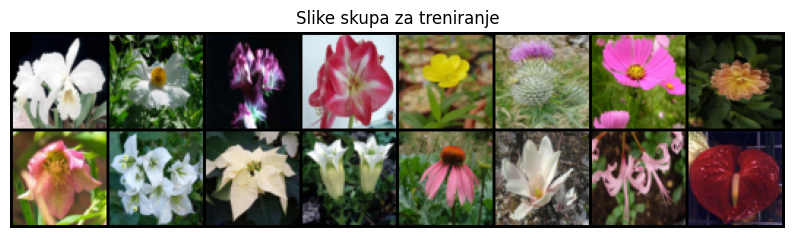

In [6]:
#Pokrenuti za demonstraciju

dataset = dset.Flowers102(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize((X_DIM, X_DIM)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)


batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Slike skupa za treniranje")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(),(1,2,0)))

U slijedećoj ćeliji je definirana konvolucijska neuronska mreža koju ćemo koristiti kao generator. Mreža kao ulaz u prvi sloj prima slučajni vektor i zatim ga u slijedećim slojevima postupno naduzorkuje do veličine *3x64x64* jer je cilj generirati RGB slike veličine *64x64*. Unutar svakog sloja provodimo normalizaciju i kao aktivacijsku funkciju koristimo ReLU.

In [3]:
#Pokrenuti za demonstraciju

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(

            nn.ConvTranspose2d(NOISE_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.generate(input)

U slijedećoj ćeliji je definirana konvolucijska neuronska mreža koju ćemo koristiti kao diskriminator. Ona na ulazu prima sliku, a kao izlaz daje rezultat klasifikacije koji predstavlja vjerojatnost da je ulazna slika stvarna, odnosno da nije generirana. Vrijednost od 0 do 1 dobivamo korištenjem sigmoidne aktivacijske funkcije u zadnjem sloju. Kod diskriminatora se preporuća korištenje aktivacijske funkcije *leaky ReLU* zbog stabilnijeg procesa treniranja.

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.discriminate(input).view(-1, 1).squeeze(1)

Slijedeću ćeliju koristimo za inicijalizaciju težina i pomaka modela.

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Gen = Generator().to(device)
Gen.apply(weights_init)

Dis = Discriminator().to(device)
Dis.apply(weights_init)

Discriminator(
  (discriminate): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kerne

U nastavku je definiran postupak učenja generativne suparničke mreže. Kod učenja postoje 3 glavna koraka. U prvom koraku računamo gradijente težina diskriminatora s obzirom na njegovu klasifikaciju stvarnih uzoraka iz skupa za učenje. U drugom koraku tome dodajemo vrijednosti gradijenata težina diskriminatora s obzirom na njegovu klasifikaciju lažnih uzoraka koje je generirao generator. Nakon prva dva koraka osvježimo težine diskriminatora, a težine generatora ne mijenjamo. U trećem koraku osvježavamo težine generatora s obzirom na rezultate klasifikacije primjera koje je generator generirao. Važno je napomenuti da u ovom slučaju kod računanja funkcije gubitka kao istinite oznake (engl. *ground truth labels*) koristimo oznake stvarnih uzoraka, iako su uzorci generirani. To činimo jer je cilj poboljšati generator, odnosno želimo postići to da diskriminator za generirane uzorke daje oznake stvarnih uzoraka. Težine diskriminatora u ovom koraku fiksiramo i ne mijenjamo.

Funkcija gubitka koju koristmo je binarna unakrsna entropija (engl *binary cross-entropy*) pošto se na visokoj razini ovdje radi o jednostavnoj klasifikaciji slika u dvije klase, lažne i stvarne.

Kod treniranja generativnih suparničkih mreža nema smisla promatrati vrijednosti funkcije gubitka kroz epohe treniranja jer gubitak ovisi o diskriminatoru koji se iz epohe u epohu mijenja i optimizira. Samim time vrijednosti gubitka nisu korelirane s kvalitetom generiranih slika, odnosno gubitak može rasti zbog povećane kvalitete diskriminatora dok u isto vrijeme raste i kvaliteta generiranih uzoraka.

In [17]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(Dis.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(Gen.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # Korak 1
        Dis.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        output = Dis(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Korak 2
        noise = torch.randn(b_size, NOISE_DIM, 1, 1, device=device)
        fake = Gen(noise)
        label.fill_(FAKE_LABEL)
        output = Dis(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        optimizerD.step()

        
        # Korak 3
        Gen.zero_grad()
        label.fill_(REAL_LABEL)
        output = Dis(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()

        optimizerG.step()

    print(f"{epoch+1}/{EPOCH_NUM} epochs completed.")

1/200 epochs completed.
2/200 epochs completed.
3/200 epochs completed.
4/200 epochs completed.
5/200 epochs completed.
6/200 epochs completed.
7/200 epochs completed.
8/200 epochs completed.
9/200 epochs completed.
10/200 epochs completed.
11/200 epochs completed.
12/200 epochs completed.
13/200 epochs completed.
14/200 epochs completed.
15/200 epochs completed.
16/200 epochs completed.
17/200 epochs completed.
18/200 epochs completed.
19/200 epochs completed.
20/200 epochs completed.
21/200 epochs completed.
22/200 epochs completed.
23/200 epochs completed.
24/200 epochs completed.
25/200 epochs completed.
26/200 epochs completed.
27/200 epochs completed.
28/200 epochs completed.
29/200 epochs completed.
30/200 epochs completed.
31/200 epochs completed.
32/200 epochs completed.
33/200 epochs completed.
34/200 epochs completed.
35/200 epochs completed.
36/200 epochs completed.
37/200 epochs completed.
38/200 epochs completed.
39/200 epochs completed.
40/200 epochs completed.
41/200 ep

Iz slijedeće usporedbe stvarnih i generiranih slika možemo vidjeti da čak i korištenjem relativno jednostavnog modela možemo dobiti rezultate koji nalikuju na stvarne primjere.

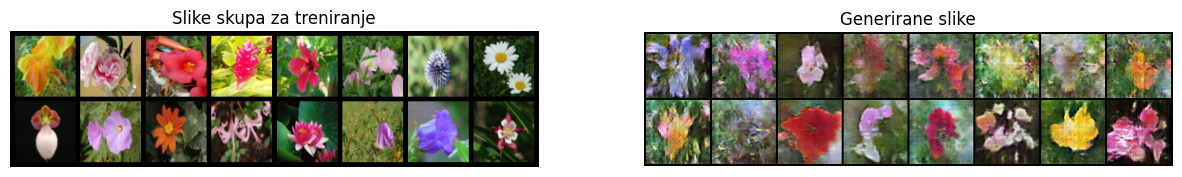

In [18]:
noise = torch.randn(16, NOISE_DIM, 1, 1, device=device)
fake = Gen(noise).detach().cpu()
fake=vutils.make_grid(fake, padding=2, normalize=True)

real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Slike skupa za treniranje")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generirane slike")
plt.imshow(np.transpose(fake,(1,2,0)))
plt.show()

In [19]:
torch.save(Gen, "./models/generator.pt")
torch.save(Dis, "./models/discriminator.pt")

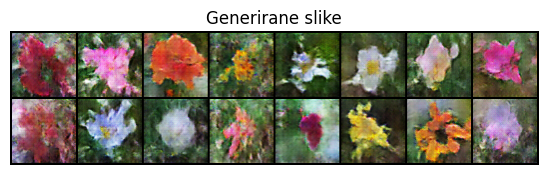

In [4]:
#Pokrenuti za demonstraciju

Gen1 = torch.load("./models/generator.pt")
noise = torch.randn(16, NOISE_DIM, 1, 1, device=device)
fake = Gen1(noise).detach().cpu()
fake=vutils.make_grid(fake, padding=2, normalize=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generirane slike")
plt.imshow(np.transpose(fake,(1,2,0)))
plt.show()

### Difuzijski modeli

Difuzijski modeli (engl. *diffusion models*) su probabilistički modeli koji pri treniranju kao ulaze dobivaju stvarne uzorke i njihov cilj je na izlazu reproducirati te uzorke. To rade na način da u prvoj fazi prolaza postupno dodaju Gaussov šum na originalnu sliku, a zatim, nakon što je dodavanjem šuma originalna slika pretvorena u čisti Gaussov šum, postupno uklanjaju šum kako bi dobili originalnu sliku. Ovaj postupak je opravdan jer u konačnici želimo dobiti generativni model koji je u stanju iz slučajnog ulaza, koji je u ovom slučaju Gaussov šum, proizvesti nove uzorke koji nalikuju onima iz skupa za učenje.

<img src="./images/Screenshot 2023-12-22 141044.png" alt="Alternative text" />

Često korištena arhitektura za difuzijske modele je U-Net. U-Net je originalno osmišljen za segmentaciju medicinskih fotografija, no pogodan je i za ovaj zadatak. Primjer U-Net arhitekture je vidljiv na slici.

<img src="./images/Screenshot 2023-12-22 141509.png" alt="Alternative text" />

U-Net je konvolucijski autoenkoder koji sadrži i preskočne veze (engl. *skip connections*) između koderskih i dekoderskih slojeva. U nastvaku ćemo U-Net koristiti na slijedeći način. Na ulaz mreže dovoditi ćemo slike iz skupa za učenje na koje je dodan šum. Šum se slikama dodaje prema određenom rasporedu koji nam garantira da će se u zadnjem vremenskom koraku slika sastojati od čistog Gaussovog šuma. Primjer postupnog zašumljavanja slika u različitim vremenskim koracima možemo vidjeti na izlazu slijedeće ćelije. Tijekom treniranja mreže, na slike iz skupa za učenje dodavati će se šum u nasumičnim vremenskim trenutcima rasporeda. Te slike ćemo dovesti na ulaz modela, koji će na izlazu proizvesti procjenu šuma dodanog u zadnjem vremenskom trenutku. Zatim ćemo od ulazne slike oduzeti procijenjeni šum i dobivenu sliku ponovo koristiti kao ulaz modela. Ovaj postupak ćemo ponoviti onoliko puta koliko je vremenskih trenutaka dodavanja šuma korišteno pri zašumljavanju originalne slike. Akumulacijom procjena modela u svim vremenskim trenutcima dobivamo ukupnu procjenu dodanog šuma, koju zatim koristimo za izračun funkcije gubitka. Funkcija gubitka je srednja kvadratna pogreška između procjene šuma i stvarnog šuma koji je dodan slici. 

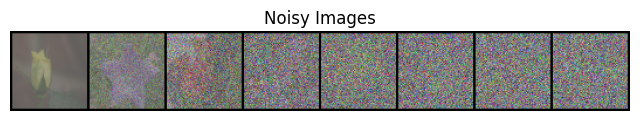

In [7]:
#Pokrenuti za demonstraciju

from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

real_batch = next(iter(dataloader))[0][:8]
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(real_batch)
noisy_batch = noise_scheduler.add_noise(real_batch, noise, timesteps)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Noisy Images")
plt.imshow(np.transpose(vutils.make_grid(noisy_batch.to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

U slijedećoj ćelije je definiran U-net model koji ćemo trenirati na istom skupu podataka kao i GAN iz prethodnog primjera.

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=X_DIM,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device);

U slijedećoj ćeliji je definiran postupak treniranja modela. U svakom koraku možemo vidjeti uzorkovanje šuma i vremenskih trenutaka. Za razliku od generativnih suparničkih mreža, difuzijski modeli imaju gubitak koji kroz vrijeme pada i koreliran je s kvalitetom modela.

In [10]:
import torch.nn.functional as F

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(f"Current device is {device}.")

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

EPOCH_NUM = 50

for epoch in range(EPOCH_NUM):
    for step, batch in enumerate(dataloader):
        clean_images = batch[0].to(device)
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

    loss_last_epoch = sum(losses[-len(dataloader) :]) / len(dataloader)
    print(f"{epoch+1}/{EPOCH_NUM} epochs completed. Loss: {loss_last_epoch}")

Current device is cuda.
1/50 epochs completed. Loss: 0.12509205203969032
2/50 epochs completed. Loss: 0.09959313174476847
3/50 epochs completed. Loss: 0.08808970678364858
4/50 epochs completed. Loss: 0.07357937906635925
5/50 epochs completed. Loss: 0.08592295163543895
6/50 epochs completed. Loss: 0.08382796074147336
7/50 epochs completed. Loss: 0.07578679075231776
8/50 epochs completed. Loss: 0.07858549946104176
9/50 epochs completed. Loss: 0.07722635753452778
10/50 epochs completed. Loss: 0.07954094631713815
11/50 epochs completed. Loss: 0.07149843225488439
12/50 epochs completed. Loss: 0.07020892074797302
13/50 epochs completed. Loss: 0.06981194668333046
14/50 epochs completed. Loss: 0.06636786158196628
15/50 epochs completed. Loss: 0.07150258289766498
16/50 epochs completed. Loss: 0.06714110882603563
17/50 epochs completed. Loss: 0.06546983859152533
18/50 epochs completed. Loss: 0.07059566280804574
19/50 epochs completed. Loss: 0.06505445920629427
20/50 epochs completed. Loss: 0.075

In [11]:
torch.save(model, "./models/unet.pt")

Za generiranje novih primjera na ulaz modela dovodimo slučajni uzorak iz normalne distribucije, odnosno Gaussov šum, i zatim kroz 1000 vremenskih koraka (toliko smo koraka zadali u definiciji rasporeda dodavanja šuma) provodimo smanjenje količine šuma koje smo opisali kod postupka treniranja. U slijedećim ćelijama ćemo pokazati uzorke generirane difuzijskim modelom.

100%|██████████| 1000/1000 [00:27<00:00, 35.77it/s]


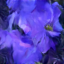

In [15]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()
pipeline_output.images[0]

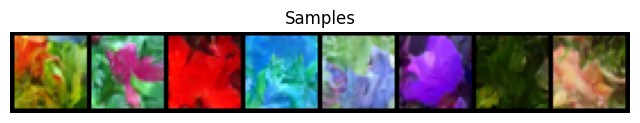

In [16]:
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    with torch.no_grad():
        residual = model(sample, t).sample

    sample = noise_scheduler.step(residual, t, sample).prev_sample

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Samples")
plt.imshow(np.transpose(vutils.make_grid(sample.to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

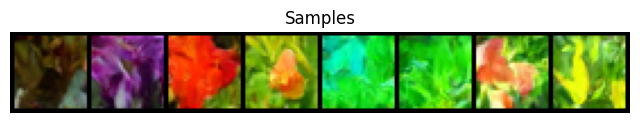

In [12]:
#Pokrenuti za demonstraciju

model = torch.load("./models/unet.pt")
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    with torch.no_grad():
        residual = model(sample, t).sample

    sample = noise_scheduler.step(residual, t, sample).prev_sample

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Samples")
plt.imshow(np.transpose(vutils.make_grid(sample.to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

## Tekstualni opisi i AttnGAN

U prethodnim primjerima smo vidjeli da se čak i uz relativno jednostavne modele može postići generiranje uvjerljivih uzoraka. Dodatnu kompleksnost u zadatak generiranja uvodimo zahtjevom da slike odgovaraju tekstualnim opisima koje korisnik zadaje. Ovaj problem predstavlja presjek između obrade prirodnog jezika (engl. *natural language processing*) i računalnog vida (engl. *computer vision*). Na početku je potrebno tekstualni upit prikazati kao vektor latentnih značajki (engl. *embedding vector*) u kojem su sadržane informacije nužne za generaciju semantički relevantnog uzorka, a zatim je potrebno na temelju tog vektora generirati uzorak. 

Jedan od načina rješavanja ovog problema je *AttnGAN* model koji osim korištenja vektora koji predstavlja cijeli tekstualni opis korisit i *attention* mehanizam kako bi na temelju pojedinih riječi opisa generirao pojedine regije uzorka.

Na slici je prikazana arhitektura *AttnGAN* modela preuzeta iz originalnog znanstvenog rada.

<img src="./images/Screenshot 2023-12-22 154056.png" alt="Alternative text" />

*AttnGAN* model je značajno složeniji od *GAN* modela iz prethodnog primjera. *AttnGAN* problem generiranja slika na temelju opisa predstavlja kao *sequnce-to-sequence* problem, te pri tome koristi najveći napredak u rješavanju takvih problema, a to je *attention* mehanizam. U nastavku slijedi detaljan opis arhitekture *AttnGAN*.

Počnimo od kodera tekstualnih opisa (na slici *Text Encoder*). Za kodiranje teksta koristi se dvosmjerna LSTM (*bidirectional long short-term memory*) ćelija koja obrađuje tekst kao niz riječi, prolazeči kroz njega unaprijedno i unazadno. Izlazi kodera su značajke riječi (na slici *word features*) *e*, koje su dobivene konkatenacijom stanja kodera za svaku pojedinu riječ u unaprijednom i unazadnom prolazu, i značajke rečenice (na slici *sentence features*) $\overline{e}$, koje su zapravo zadnje stanje kodera.

Slijedeća komponenta je *conditional augmentation* (na slici $F^{ca}$). Ona služi za transformaciju značajki rečenice u ulaz generativnog dijela modela, i to čini u nekoliko koraka. U prvom koraku iz značajki rečenice generira srednju vrijednost $\mu$ i standardnu devijaciju $\sigma$ normalne razdiobe iz koje se zatim uzima uzorak koristeći reparametrizaciju
$$c=\mu+\sigma\cdot\epsilon, \epsilon \sim N(0,I).$$
Ovisnost parametara $\mu$ i $\sigma$ o značajkama rečenice modelirana je potpuno povezanim slojem. Na taj se uzorak konkatenira uzorak $Z$ iz standardne normalne razdiobe. Uzorkovanje je korišteno kako bi se postigla veća varijabilnost generiranih slika, odnosno kako bi se čak i za iste opise dobivali različiti rezultati.

Nakon toga dolazimo do prvog generatora $F_0$. $F_0$ generator koristimo za naduzorkovanje ulaza do dimenzije $64x64xC$, gdje $C$ predstavlja broj kanala. Kod naduzorkovanja se koristi interpolacija najbližim susjedom. Izlaz generatora $F_0$ označavamo s $h_0$. 

Prva komponenta *attention* mehanizma označena je s $F^{attn}_1$. Ova komponenta idejno računa koliko je koja riječ ulaznog opisa utjecala na generiranje pojedinih regija slike. U prvom koraku se značajke riječi $e$ provuku kroz potpuno povezani sloj kako bi njihova dimenzionalnost odgovarala dimenzionalnosti $h_0$. Svaki stupac $(h_0)_j$ predstavlja značajke $j$-te regije slike. Za svaku regiju se računa *word-context vector* $c_j$, koji predstavlja riječi koje su relevantne za generiranje te regije.
$$c_j=\sum ^{T-1}_{i=0} \beta_{j,i}\cdot e_i',$$
gdje je $\beta_{j,i}=\frac{exp(s_{j,i})}{\sum ^{T-1}_{i=0} exp(s_{j,k})}$ i $s_{j,i}=h_j^T\cdot e_i'$. Odnosno *word-context vector* regije predstavlja težinsku sumu značajki riječi, otežanu po relevantnosti riječi za kreiranje regije.

Slijedeća komponenta je generator $F_1$. On kao ulaz dobiva $h_0$ i izlaz komponente $F^{attn}_1$, a zatim ih kombinira i nad njima provodi naduzorkovanje interpolacijom najbližim susjedom do veličine $128x128xC$, gdje $C$ predstavlja broj kanala. Izlaz generatora $F_0$ označavamo s $h_1$. Svaki generator $F_i$, $i\ge1$, ima istu strukturu i zadaću.

Druga komponenta *attention* mehanizma je $F^{attn}_2$. Po svojoj namjeni i strukturi je identična kao $F^{attn}_1$, a jednina razlika je to što $F^{attn}_2$ kao ulaz dobiva $h_1$ umjesto $h_0$.

Generator $F_2$ funkcionira isto kao i generator $F_1$, osim što na ulazu dobiva $h_1$ i izlaz $F^{attn}_2$.

Ovdje je važno napomenuti da se dodavanjem dodatnih generatora i *attention* slojeva mogu dobiti generirani uzorci još većih rezolucija (jer je izlaz svakog slijedećeg generatora dvostruko veći), no, kao što autori rada navode, to značajno povećava potrebne računalne resurse za treniranje i korištenje modela.

Generatori $G_0$, $G_1$ i $G_2$ rade na identičan način. Svi kao ulaz primaju izlaz prijašnjeg $F$ generatora koji je veličine $HxWxC$, i njihova zadaća je samo smanjenje broja kanala $C$ na 3 kako bi konačne slike bile u RGB formatu.

Diskriminatori $D_0$, $D_1$ i $D_2$ na ulazu dobivaju značajke rečenice (bez dodanog šuma) i slike. Odrađuju dvije vrste zadataka, uvjetne (engl. *conditional*) i bezuvjetne (engl. *unconditional*). Kod bezuvjetnih zadataka diskriminatori klasificiraju slike kao stvarne ili lažne (generirane), a kod uvjetnih zadataka određuju odgovaraju li slika i opis međusobno.

### Gubitci

Za treniranje generatora $G_i$ koristimo suparnički gubitak (engl. *adversarial loss*) koji se, u skladu sa zadacima diskriminatora, sastoji od uvjetnog i bezuvjetnog dijela. Gubitak se računa po izrazu
$$L_{G_i}=-0.5\cdot E_{\hat{x}_i\sim P_{G_i}}(\log(D_i(\hat{x}_i)))-0.5\cdot E_{\hat{x}_i\sim P_{G_i}}(\log(D_i(\hat{x}_i, \overline{e}))),$$
gdje prvi član predstavlja bezuvjetni gubitak, odnosno gubitak klasifikacije generiranih slika kao stvarnih ili lažnih, dok drugi član predstavlja uvjetni gubitak, odnosno gubitak klasifikacije sukladnosti slike i opisa. U izrazima za očekivanje možemo vidjeti da primjeri $\hat{x}_i$ dolaze iz distribucije $P_{G_i}$, što znači da gubitak generatora računamo samo za primjere koje su generirali.

Kod treniranja diskriminatora koristimo gubitak unakrsne entropije, koji se također sastoji od uvjetnog i bezuvjetnog dijela. Izraz za računanje gubitka diskriminatora je
$$L_{G_i}=-0.5\cdot E_{x_i\sim P_{data}}(\log(D_i(x_i)))-0.5\cdot E_{\hat{x}_i\sim P_{G_i}}(\log(1-D_i(\hat{x}_i)))\\-0.5\cdot E_{x_i\sim P_{data}}(\log(D_i(x_i, \overline{e})))-0.5\cdot E_{\hat{x}_i\sim P_{G_i}}(\log(1-D_i(\hat{x}_i, \overline{e}))),$$
gdje prvi red predstavlja bezuvjetni gubitak, a drugi red uvjetni. Gubitak diskriminatora računamo i za stvarne i za generirane primjere, što možemo vidjeti po distribucijama unutar izraza za očekivanje.

Posljednji dio arhitekture modela je *Deep Attentional Multimodal Similarity Model*, ili $DAMSM$. $DAMSM$ koristi izlaze kodera konačnih izlaznih slika (na slici *Image Encoder*). Koder slika služi kako bi se iz slika dobile lokalne i globalne značajke. To se postiže korištenjem konvolucijske neuronske mreže *Inception-V3* predtrenirane na *ImageNet* skupu podataka. Slika se dovodi na ulaz kodera, a zatim se vrijednosti jednog od slojeva dimenzija *768x289* koriste kao lokalne značajke slike *f*, pri čemu se broj *289* smatra brojem regija slike. U konačnici se kao globalne značajke slike $\overline{f}$ koriste vrijednosti iz zadnjeg sloja sažimanja srednjom vrijednosti.
$DAMSM$ idejno provjerava jesu li slike u skladu s tekstualnim opisom, i to ostvaraju u nekoliko koraka. 

1. Značajke $f$ i $\overline{f}$ se provuku kroz potpuno povezani sloj kako bi im dimenzije odgovarale dimenzijama značajki tekstualnog opisa $e$ i $\overline{e}$.

2. Zatim matrično pomnožimo matrice lokalnih značajki opisa i slike i dobijemo matricu $S$ dimenzija $Tx289$, gdje je $T$ broj riječi u opisu. Elementi matrice predstvaljaju relevantnost riječi za pojedinu regiju. Elemente matrice normaliziramo i dobijemo $\overline{S}$.

3. Računamo *region-context vector* za svaku riječ po izrazu
$$c_i=\sum_{j=0}^{288}\alpha _j\cdot v_j,$$
gdje je $\alpha_j=\frac{exp(\gamma _1\cdot\overline{s}_{i,j})}{\sum_{k=0}^{288}exp(\gamma _1\cdot\overline{s}_{i,k})}$. Drugim riječima, za svaku riječ računamo težinsku sumu vektora značajki regija slika, otežanu po relevantnosti riječi za pojedinu regiju. $\gamma _1$ je hiperparametar modela.

4. Računamo *word-level relevance* $R(c_i, e_i)$ za i-tu riječ kao kosinusovu sličnost *region-context vector-a* i vektora značjki riječi. Time dobivamo mjeru koja nam govori koliko je koja riječ bila važna za generiranje slike.

5. Računamo sukladnost opisa $D$ i slike $Q$ na razini riječi kao
$$R_1(Q,D)=\log\left(\sum_{i=0}^{T-1}exp(\gamma_2\cdot R(c_i, e_i))\right)^{\frac{1}{\gamma_2}},$$
gdje je $\gamma_2$ hiperparametar modela, i na razini cijelog opisa kao
$$R_2(Q,D)=\frac{\overline{v}^T\cdot \overline{e}}{||\overline{v}||\cdot ||\overline{e}||},$$
odnosno kao kosinusovu sličnost vektora značajki rečenice i vektora globalnih značajki slike.

6. Zatim računamo posteriorne vjerojatnosti da slika $Q_i$ odgovara opisu $D_i$, i da opis $D_i$ odgovara slici $Q_i$, kao
$$P(D_i|Q_i)=\frac{exp(\gamma_3\cdot R(Q_i, D_i))}{\sum_{j=1}^{M}exp(\gamma _3\cdot R(Q_i, D_j))}$$
i
$$P(Q_i|D_i)=\frac{exp(\gamma_3\cdot R(Q_i, D_i))}{\sum_{j=1}^{M}exp(\gamma _3\cdot R(Q_j, D_i))}.$$
$\gamma_3$ je hiperparametar modela.

7. Konačan $DAMSM$ gubitak je
$$L_{DAMSM}=R_1(Q,D)\cdot P(D_i|Q_i)+R_1(Q,D)\cdot P(Q_i|D_i)+R_2(Q,D)\cdot P(D_i|Q_i)+R_2(Q,D)\cdot P(Q_i|D_i),$$
a konačan gubitak modela je
$$L=L_G+\lambda \cdot L_{DAMSM},$$
gdje je $\lambda$ hiperparametar modela, a $L_G$ je suma gubitaka generatora.

### Rezultati

Ukratko ćemo prikazati rezultate originalnog rada na *CUB* skupu podataka koji ćemo kasnije koristiti za reprodukciju rezultata. Slijedeća slika je preuzeta iz originalnog rada.

<img src="./images/Screenshot 2023-12-24 140405.png" alt="Alternative text" />

Gornje 3 slike redom prikazuju izlaze iz generatora $G_0$, $G_1$ i $G_2$. Možemo vidjeti da model kod prve generacije shvaća globalne, općenite značajke slike, kao što su oblik ptice, boje i prirodna pozadina. To je za očekivati pošto prvi generator kao ulaz dobiva samo globalne značajke rečenice. Druga i treća slika postupno dodaju dodatne detalje kojima pristupaju pomoću lokalnih značajki pojedinih riječi korištenjem *attention* mehanizma. Donja dva reda predstavljaju riječi koje su bile najvažnije za generiranje pojedinih dijelova slika na temelju izlaza komponenti $F^{attn}_1$ i $F^{attn}_2$.

### Reprodukcija rezultata

Autori rada su javno objavili korišteni kod i parametre predtreniranih modela. Uz potrebne preinake dostupnog koda i smanjenje parametra za veličinu *batch-a*, kako bi generiranje bilo izvedivo na osobnom računalu, dobivene su slike za sve tekstualne opise u skupu za validaciju. Primjeri slika i tekstualnih opisa vidljivi su u nastavku.

<figure>
<img src="./images/Yellow_Billed_Cuckoo_0009_26656_s-1.png" alt="Alternative text" />
<figcaption>"The bird has a white throat, abdomen, and small tarsus as well as orange lower bill and black upper bill."</figcaption>
</figure>

<figure>
<img src="./images/Black_Throated_Sparrow_0010_107375_s-1.png" alt="Alternative text" />
<figcaption>"This bird is grey in color, small in size, and has white eyebrows."</figcaption>
</figure>

<figure>
<img src="./images/Indigo_Bunting_0021_13979_s-1.png" alt="Alternative text" />
<figcaption>"This bird is blue with black on its wings and has a very short beak."</figcaption>
</figure>

<figure>
<img src="./images/Purple_Finch_0043_28117_s-1.png" alt="Alternative text" />
<figcaption>"A dull red headed bird with a white and red breast, with dark brown wings."</figcaption>
</figure>

Gornje 4 slike su primjeri uspješnog generiranja, no često dolazi i do sasvim neprepoznatljivih slika. Nekoliko takvih primjera je vidljivo u nastavku.

<img src="./images/Mockingbird_0083_79862_s-1.png" alt="Alternative text" /><img src="./images/Pomarine_Jaeger_0072_795743_s-1.png" alt="Alternative text" /><img src="./images/Western_Gull_0089_55306_s-1.png" alt="Alternative text" /><img src="./images/White_Pelican_0081_96148_s-1.png" alt="Alternative text" />